# Credit Risk Analysis – Results
This notebook presents the key findings and visualizations from an analysis of loan default risk.  
The goal is to identify the main drivers of default and highlight high-risk borrowers using a simple, interpretable model.

I analyzed a dataset of 32,566 loan applications, focusing on borrower characteristics and loan features.  
The target variable is whether a borrower defaulted ('loan_status'), and I modeled the risk using logistic regression.  

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
# load dataset
df = pd.read_csv('../data/processed/credit_risk_cleaned.csv')

# 1. Default rate by loan purpose
Shows which loan purposes are most risky for default.

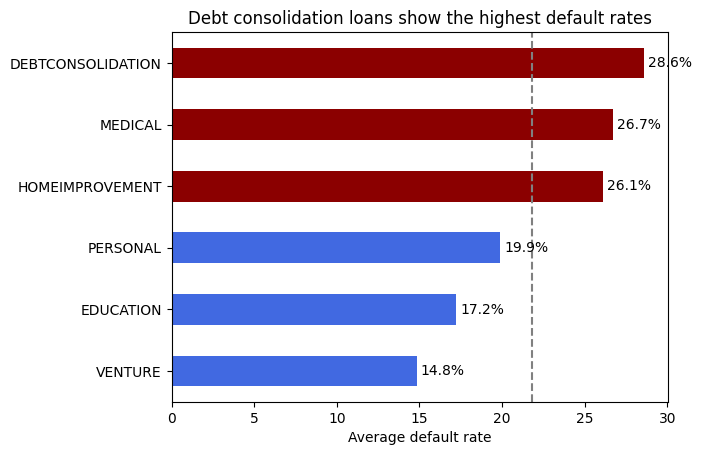

In [ ]:
# Default rate by loan purpose
fig, ax = plt.subplots()

# Color bars: red if above overall mean risk
colors = ['royalblue','royalblue', 'royalblue', 'darkred','darkred', 'darkred']
mean_risk = df['loan_status'].mean() * 100

loan_intent = (df.groupby('loan_intent')['loan_status'].mean() * 100).sort_values()
loan_intent.plot(kind='barh',
                 title='Debt consolidation loans show the highest default rates',
                 xlabel='Average default rate',
                 ylabel='',
                 color= colors,ax=ax)

# put percentage labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

ax.axvline(mean_risk, color='gray', linestyle='--', label='Average default rate')

plt.show()


Borrowers taking loans for debt consolidation, medical and home improvement purposes show higher default rates. Bars above the gray line indicate above-average risk. 

# 2. Default rate by home ownership
Compares risk levels for renters, owners, etc.

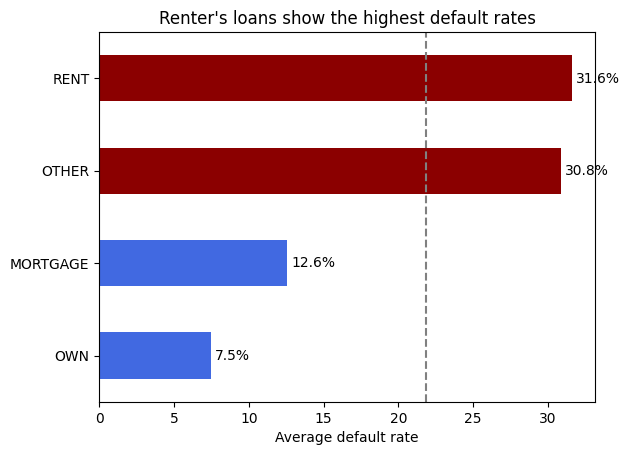

In [4]:
# Default rate by home ownership
fig, ax = plt.subplots()

# Color bars: red if above overall mean risk
colors = ['royalblue','royalblue', 'darkred', 'darkred']

home_ownership = (df.groupby('person_home_ownership')['loan_status'].mean() * 100).sort_values()
home_ownership.plot(kind='barh',
                 title="Renter's loans show the highest default rates",
                 xlabel='Average default rate',
                 ylabel='',
                 color= colors,ax=ax)

# put percentage labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

ax.axvline(mean_risk, color='gray', linestyle='--', label='Average default rate')

plt.show()

Renters tend to have a slightly higher default rate than homeowners,suggesting that financial stability (proxied by home ownership) may reduce credit risk.

# 3. Actual vs historical default
Checks if borrowers with past defaults tend to default again.

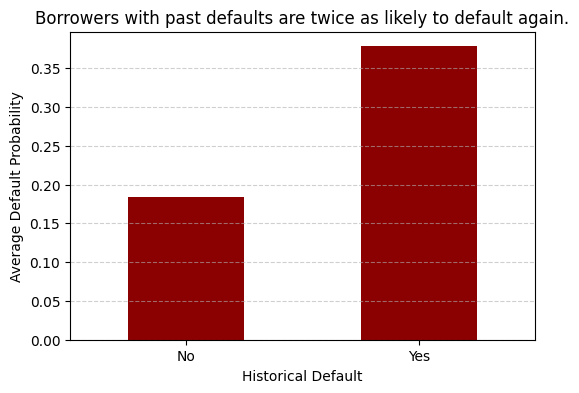

In [5]:
# Actual vs historical default
fig, ax = plt.subplots(figsize=(6,4))

# mean default rate per group
high_risk_counts = df.groupby('default')['loan_status'].mean()  
high_risk_counts.plot(kind='bar', color='darkred', ax=ax)

ax.set_ylabel('Average Default Probability')
ax.set_title('Borrowers with past defaults are twice as likely to default again.')
ax.xaxis.set_tick_params(rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_xticklabels(['No', 'Yes'])
ax.set_xlabel('Historical Default')

plt.show()

Borrowers who previously defaulted have a much higher probability of defaulting again.

# 4. Prediction with logistic regression
Shows how default probability increases with the loan-to-income ratio.

In [18]:
# Fit logistic regression
model = smf.logit('loan_status ~ loan_percent_income + loan_int_rate', data=df)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.403357
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                32566
Model:                          Logit   Df Residuals:                    32563
Method:                           MLE   Df Model:                            2
Date:                Wed, 15 Oct 2025   Pseudo R-squ.:                  0.2312
Time:                        15:14:17   Log-Likelihood:                -13136.
converged:                       True   LL-Null:                       -17086.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -6.3044      0.079    -79.926      0.000      -6.459      -6.150
loan_percent_income     8.7063      0.147     59.166      0.000       8.418       8.995
loan_int_rate           0.2835      0.005     52.920      0.000       0.273       0.294
=======================================================================================
"""

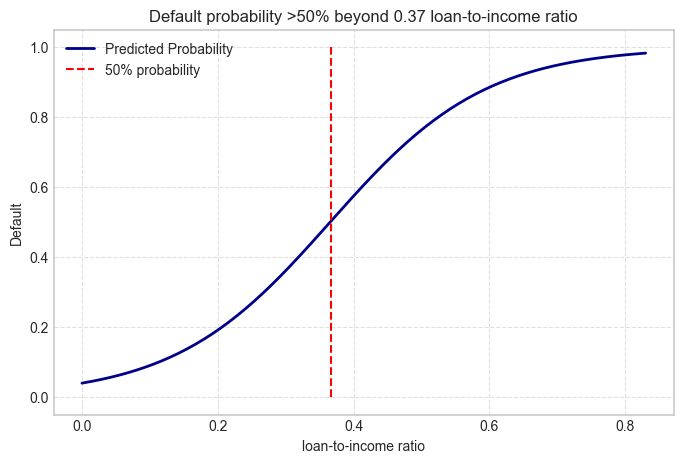

In [19]:
# Probability curve with 50% threshold
x_range = np.linspace(df['loan_percent_income'].min(),
                      df['loan_percent_income'].max(),
                      200)
X_df = pd.DataFrame({'loan_percent_income': x_range,
                     'loan_int_rate': df['loan_int_rate'].mean()})
p_y = results.predict(X_df)

x_50 = X_df['loan_percent_income'][p_y >= 0.5].iloc[0]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(x_range, p_y, color='darkblue', linewidth=2, label='Predicted Probability')
ax.vlines(x=x_50, ymin=0, ymax=1, colors='red', linestyles='--', label='50% probability')

# labels
ax.set_xlabel('loan-to-income ratio')
ax.set_ylabel('Default')
ax.set_title('Default probability >50% beyond 0.37 loan-to-income ratio')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.show()

 50% probability threshold: borrowers with loan-to-income ratio above ~0.37 are high-risk.  

# 5. Distribution of predicted probabilities
Shows how many borrowers the model considers low, medium, or high risk.

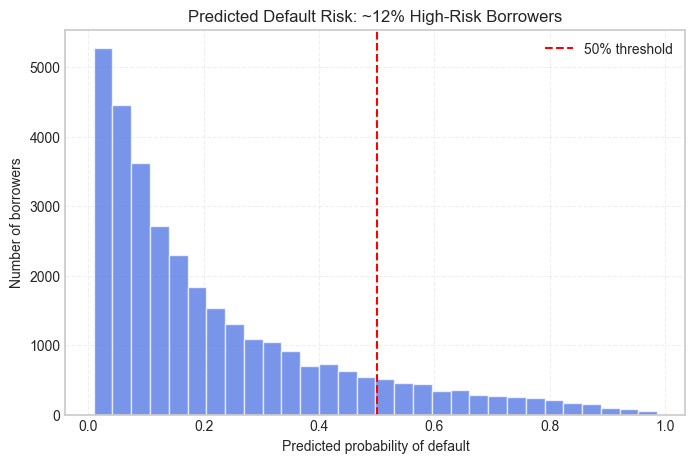

In [20]:
# Predict probabilities for each borrower
sns.set_style("whitegrid")
pred_probs = results.predict(df[['loan_percent_income','loan_int_rate']])

fig, ax = plt.subplots(figsize=(8,5))
ax.hist(pred_probs, bins=30, color='royalblue', alpha=0.7)
ax.axvline(0.5, color='red', linestyle='--', label='50% threshold')

ax.set_title("Predicted Default Risk: ~12% High-Risk Borrowers")
ax.set_xlabel("Predicted probability of default")
ax.set_ylabel("Number of borrowers")
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend()

plt.show()

This visualization helps identify how many clients the model classifies as risky and gives an overview of the overall risk profile.

Most borrowers have a low predicted probability of default. A smaller group lies to the right of the red dashed line — these are considered high-risk customers.

Only ~12% (3850) borrowers cross the 50% treshold and classified as high-risk.
The portfolio is generally healthy, but a small high-risk segment deserves closer attention.